# Job Recommendation

with dataset from Careerbuilder

## TOC
* [Import dependencies](#import)
* [Load dataset](#dataset)
* [EDA and Preprocessing](#EDA)
 - [split into training and testing dataset](#split)
 - [location](#location)
 - [preprocessing](#preprocessing)
* [Building model](#model)
* [Clean html](#html)
 - [Tokenising](#token)
* [Text processing](#textprocessing)
 - [BOW model](#bow)
 - [Term frequency-inverse document frequency](#tfidf)

* [similar users](#similarusers)

## Import dependencies <a class="anchor" id="import"></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Load dataset <a class="anchor" id="dataset"></a>

In [2]:
!ls data/*.tsv

data/apps.tsv  data/test_users.tsv    data/users.tsv
data/jobs.tsv  data/user_history.tsv  data/window_dates.tsv


- users
- jobs
- apps
- users_history
- test_users

In [3]:
users = pd.read_csv('data/users.tsv', sep='\t', encoding='utf-8')
jobs = pd.read_csv('data/jobs.tsv', sep='\t', encoding='utf-8', error_bad_lines=False)
apps = pd.read_csv('data/apps.tsv', sep='\t', encoding='utf-8')
user_history = pd.read_csv('data/user_history.tsv', sep='\t', encoding='utf-8')
test_users = pd.read_csv('data/test_users.tsv', sep='\t', encoding='utf-8')

# jobs = pd.read_csv('data/jobs.tsv', sep='\t')

b'Skipping line 122433: expected 11 fields, saw 12\n'
b'Skipping line 602576: expected 11 fields, saw 12\n'
b'Skipping line 990950: expected 11 fields, saw 12\n'
/home/hectoryee/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
users.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [5]:
users.columns

Index(['UserID', 'WindowID', 'Split', 'City', 'State', 'Country', 'ZipCode',
       'DegreeType', 'Major', 'GraduationDate', 'WorkHistoryCount',
       'TotalYearsExperience', 'CurrentlyEmployed', 'ManagedOthers',
       'ManagedHowMany'],
      dtype='object')

In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389708 entries, 0 to 389707
Data columns (total 15 columns):
UserID                  389708 non-null int64
WindowID                389708 non-null int64
Split                   389708 non-null object
City                    389708 non-null object
State                   389218 non-null object
Country                 389708 non-null object
ZipCode                 387974 non-null object
DegreeType              389708 non-null object
Major                   292468 non-null object
GraduationDate          269477 non-null object
WorkHistoryCount        389708 non-null int64
TotalYearsExperience    375528 non-null float64
CurrentlyEmployed       347632 non-null object
ManagedOthers           389708 non-null object
ManagedHowMany          389708 non-null int64
dtypes: float64(1), int64(4), object(10)
memory usage: 44.6+ MB


In [7]:
jobs.replace('NaN',np.NaN)
jobs.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59


In [8]:
apps.head()

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [9]:
user_history.head()

,UserID,WindowID,Split,Sequence,JobTitle
0,47,1,Train,1,National Space Communication Programs-Special ...
1,47,1,Train,2,Detention Officer
2,47,1,Train,3,"Passenger Screener, TSA"
3,72,1,Train,1,"Lecturer, Department of Anthropology"
4,72,1,Train,2,Student Assistant


In [10]:
test_users.head()

,UserID,WindowID
0,767,1
1,769,1
2,861,1
3,1006,1
4,1192,1


## EDA and Preprocessing <a class="anchor" id="EDA"></a>

### Splitting into Training and Testing dataset <a class="anchor" id="split"></a>

with attribute split:
- users
- apps
- user_history

### users

In [11]:
users_training = users.loc[users['Split'] == 'Train']
users_training.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [12]:
users_training.shape

(366870, 15)

In [13]:
users_testing = users.loc[users['Split'] == 'Test']

In [14]:
users_testing.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
31,767,1,Test,Murrieta,CA,US,92562,Bachelor's,University Studies/Business,2008-05-01 00:00:00,5,16.0,No,No,0
32,769,1,Test,Roselle,IL,US,60172,Bachelor's,Radio-Television,2011-05-01 00:00:00,5,5.0,Yes,No,0
33,861,1,Test,Morris,IL,US,60450,High School,General Studies,1989-05-01 00:00:00,7,21.0,NaN,No,0
38,1006,1,Test,West Chester,PA,US,19382,High School,Not Applicable,2008-06-01 00:00:00,3,6.0,Yes,No,0
44,1192,1,Test,Cincinnati,OH,US,45255,Bachelor's,Marketing,NaN,5,6.0,Yes,No,0


### apps

In [15]:
apps_training = apps.loc[apps['Split'] == 'Train']
apps_training.head()

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [16]:
apps_training.shape

(1417514, 5)

In [17]:
apps_testing = apps.loc[apps['Split'] == 'Test']
apps_testing.head()

,UserID,WindowID,Split,ApplicationDate,JobID
126,767,1,Test,2012-04-01 14:37:20.023,85377
127,769,1,Test,2012-04-16 22:36:52.48,853328
128,769,1,Test,2012-04-09 18:59:28.193,86106
129,769,1,Test,2012-04-09 18:59:31.127,327571
130,769,1,Test,2012-04-08 21:29:11.993,119161


In [18]:
apps_testing.shape

(185597, 5)

### user_history

In [19]:
user_history_training = user_history.loc[user_history['Split'] == 'Train']
user_history_training.head()

,UserID,WindowID,Split,Sequence,JobTitle
0,47,1,Train,1,National Space Communication Programs-Special ...
1,47,1,Train,2,Detention Officer
2,47,1,Train,3,"Passenger Screener, TSA"
3,72,1,Train,1,"Lecturer, Department of Anthropology"
4,72,1,Train,2,Student Assistant


In [20]:
user_history_training.shape

(1652513, 5)

In [21]:
user_history_testing = user_history.loc[user_history['Split'] == 'Test']
user_history_testing.head()

,UserID,WindowID,Split,Sequence,JobTitle
144,767,1,Test,1,Claims Adjuster
145,767,1,Test,2,Professional Baseball Player
146,767,1,Test,3,Professional Baseball Player
147,767,1,Test,4,Professional Baseball Player
148,767,1,Test,5,Professional Baseball Player


In [22]:
user_history_testing.shape

(101388, 5)

#### Dataframes
- users_training
- users_testing
- apps_training
- apps_testing
- user_history_training
- user_history_testing

### Location <a class="anchor" id="location"></a>

In [23]:
jobs.groupby(['City','State','Country']).size().reset_index(name='Locationwise')

,City,State,Country,Locationwise
0,&#60;&#47;b&#62; Brno &#60;b&#62;,,CZ,1
1,&#60;&#47;b&#62; Praha &#60;b&#62;,,CZ,1
2,- Any,,CZ,13
3,29 Palms,CA,US,1
4,<,,HU,1
5,<,,TR,2
6,AMF O'Hare,IL,US,2
7,APAC-Australia,,AU,68
8,Aaron,IN,US,6
9,Abanaka,OH,US,1


In [24]:
jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',ascending=False).head()

,Country,Locationwise
59,US,1090462
4,AF,560
19,CZ,193
40,MX,93
52,TR,81


In [25]:
Country_wise_job = jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise', 
                                                                                                 ascending=False)

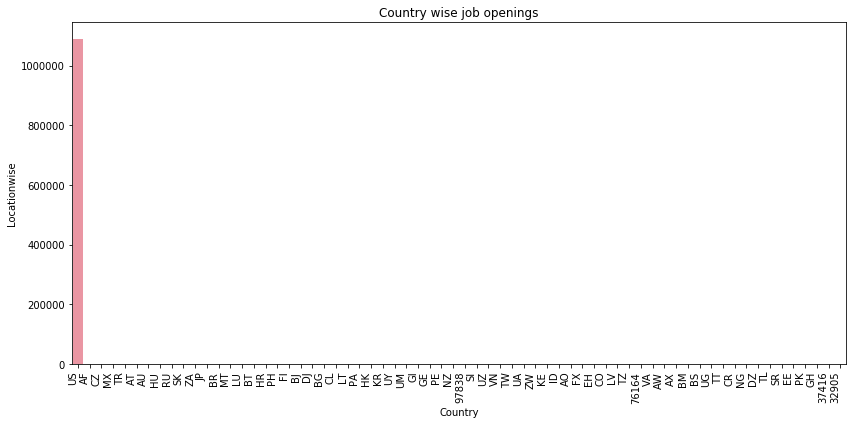

In [26]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x="Country", y="Locationwise", data=Country_wise_job)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('Country wise job openings')
plt.tight_layout()
plt.show()

## Preprocessing <a class="anchor" id="preprocessing"></a>
- Considering only US
- Removing data with empty state

In [27]:
jobs_US = jobs.loc[jobs['Country'] == 'US']

In [28]:
jobs_US[['City','State','Country']]

,City,State,Country
0,Washington,DC,US
1,Charlotte,NC,US
2,Winter Park,FL,US
3,Orlando,FL,US
4,Orlando,FL,US
5,Ormond Beach,FL,US
6,Orlando,FL,US
7,Orlando,FL,US
8,Orlando,FL,US
9,Winter Park,FL,US


In [29]:
jobs_US.groupby(['City', 'State', 'Country']).size().reset_index(name = 'Locationwise').sort_values('Locationwise', ascending = False).head()

,City,State,Country,Locationwise
6601,Houston,TX,US,19306
9835,New York,NY,US,18395
2651,Chicago,IL,US,17806
3475,Dallas,TX,US,13139
610,Atlanta,GA,US,12352


In [30]:
statewise_jobs = jobs_US.groupby(['State']).size().reset_index(name = 'Statewise').sort_values('Statewise', ascending = False)

In [31]:
statewise_jobs

,State,Statewise
5,CA,109630
48,TX,98071
10,FL,71024
16,IL,58743
38,NY,53998
42,PA,48999
39,OH,45048
34,NJ,35175
30,NC,34553
11,GA,33453


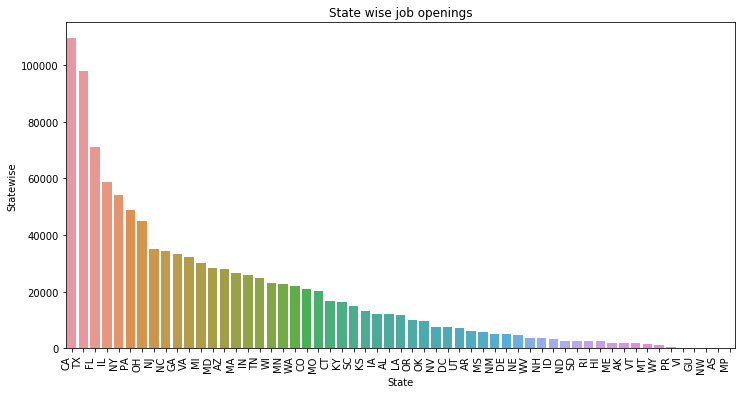

In [32]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x="State", y="Statewise",data=statewise_jobs)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha = "right")
ax.set_title("State wise job openings")
plt.tight_layout
plt.show()

In [33]:
jobs_US.groupby(['City']).size().reset_index(name='Citywise').sort_values('Citywise', ascending=False)

,City,Citywise
4564,Houston,19323
6809,New York,18402
1782,Chicago,17806
2351,Dallas,13202
408,Atlanta,12365
7650,Phoenix,12297
1709,Charlotte,10419
2056,Columbus,9323
4684,Indianapolis,9235
5632,Los Angeles,8878


In [34]:
citywise_jobs = jobs_US.groupby(['City']).size().reset_index(name='Citywise').sort_values('Citywise', ascending=False)

In [35]:
citywise_jobs

,City,Citywise
4564,Houston,19323
6809,New York,18402
1782,Chicago,17806
2351,Dallas,13202
408,Atlanta,12365
7650,Phoenix,12297
1709,Charlotte,10419
2056,Columbus,9323
4684,Indianapolis,9235
5632,Los Angeles,8878


In [36]:
citywise_top = citywise_jobs.loc[citywise_jobs['Citywise']>=12]

In [37]:
citywise_top

,City,Citywise
4564,Houston,19323
6809,New York,18402
1782,Chicago,17806
2351,Dallas,13202
408,Atlanta,12365
7650,Phoenix,12297
1709,Charlotte,10419
2056,Columbus,9323
4684,Indianapolis,9235
5632,Los Angeles,8878


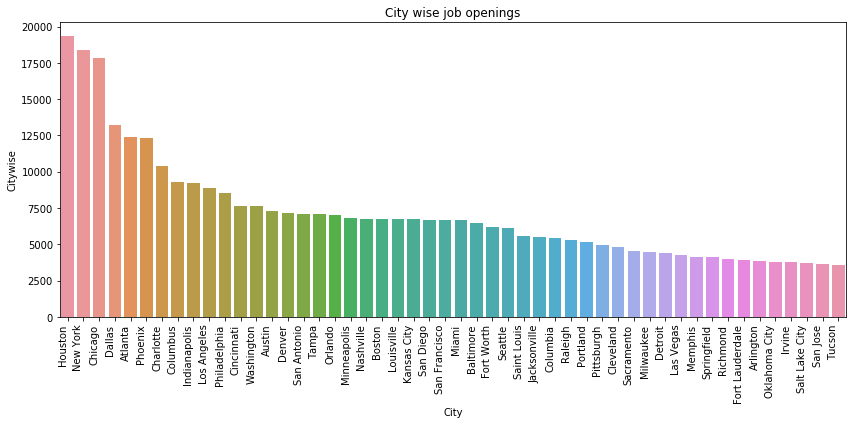

In [38]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x="City", y="Citywise",data=citywise_top.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('City wise job openings')
plt.tight_layout()
plt.show()

- jobs_US
- statewise_jobs
- citywise_jobs
- citywise_jobs_top

### User profile based on location

In [39]:
users_training.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise', ascending=False)

,Country,Locationwise
105,US,365740
47,IN,236
18,CA,108
81,PH,59
82,PK,59
71,MX,48
103,UK,39
31,ES,37
33,FR,31
50,IT,29


In [40]:
users_training_US = users_training.loc[users_training['Country'] == 'US']
users_training_US.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [41]:
users_training_US.shape

(365740, 15)

In [42]:
users_training_statewise = users_training_US.groupby('State').size().reset_index(
    name='statewise').sort_values('statewise',ascending=False)
users_training_statewise.head()

,State,statewise
11,FL,40381
47,TX,33260
6,CA,31141
17,IL,22557
37,NY,19299


In [43]:
users_training_statewise_top = users_training_statewise.loc[users_training_statewise['statewise'] >= 12]

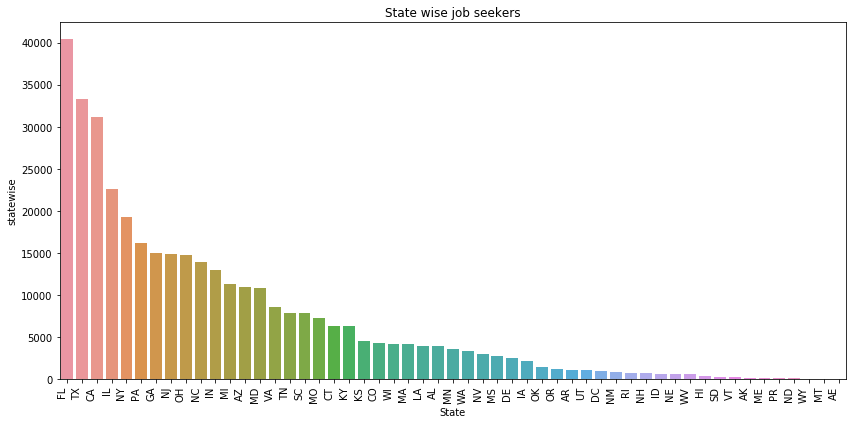

In [44]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x='State', y='statewise', data=users_training_statewise_top)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
ax.set_title('State wise job seekers')
plt.tight_layout()
plt.show()

In [45]:
users_training_citywise = users_training_US.groupby(['City']).size().reset_index(
    name='citywise').sort_values('citywise',ascending=False)
users_training_citywise.head()

,City,citywise
1528,Chicago,6964
4066,Houston,5487
4177,Indianapolis,4450
5604,Miami,4359
6965,Philadelphia,4347


In [46]:
users_training_citywise_top = users_training_citywise.loc[users_training_citywise['citywise'] >= 12]
users_training_citywise_top.head()

,City,citywise
1528,Chicago,6964
4066,Houston,5487
4177,Indianapolis,4450
5604,Miami,4359
6965,Philadelphia,4347


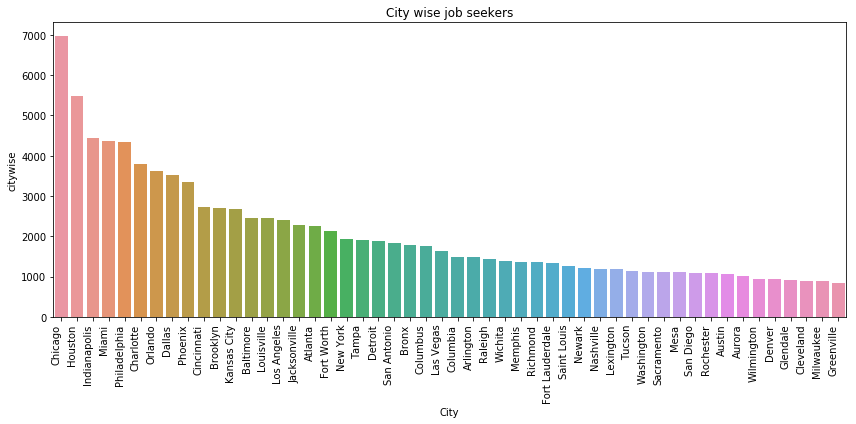

In [47]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x='City', y='citywise', data=users_training_citywise_top.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('City wise job seekers')
plt.tight_layout()
plt.show()

- users_training_US
- users_training_statewise
- users_training_citywise
- users_training_citywise_top

In [48]:
import ast 
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
# from nltk.stem.snowball import SnowballStemmer
# from nltk.stem.wordnet import WordNetLemmatizer
# from nltk.corpus import wordnet
# from surprise import Reader, Dataset, SVD, evaluate

## Building model <a class="anchor" id="model"></a>

In [49]:
jobs_US.columns

Index(['JobID', 'WindowID', 'Title', 'Description', 'Requirements', 'City',
       'State', 'Country', 'Zip5', 'StartDate', 'EndDate'],
      dtype='object')

In [50]:
jobs_US.head().transpose()

,0,1,2,3,4
JobID,1,4,7,8,9
WindowID,1,1,1,1,1
Title,Security Engineer/Technical Lead,SAP Business Analyst / WM,P/T HUMAN RESOURCES ASSISTANT,Route Delivery Drivers,Housekeeping
Description,<p>Security Clearance Required:&nbsp; Top Secr...,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,CITY BEVERAGES Come to work for the best in th...,I make sure every part of their day is magica...
Requirements,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Please refer to the Job Description to view th...,Please refer to the Job Description to view th...,Please refer to the Job Description to view th...
City,Washington,Charlotte,Winter Park,Orlando,Orlando
State,DC,NC,FL,FL,FL
Country,US,US,US,US,US
Zip5,20531,28217,32792,NaN,NaN
StartDate,2012-03-07 13:17:01.643,2012-03-21 02:03:44.137,2012-03-02 16:36:55.447,2012-03-03 09:01:10.077,2012-03-03 09:01:11.88


In [51]:
jobs_US_base_line = jobs_US.iloc[0:10000,0:8]

In [52]:
jobs_US_base_line.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US


In [53]:
jobs_US_base_line['Title'] = jobs_US_base_line['Title'].fillna('')
jobs_US_base_line['Description'] = jobs_US_base_line['Description'].fillna('')
#jobs_US_base_line['Requirements'] = jobs_US_base_line['Requirements'].fillna('')

jobs_US_base_line['Description'] = jobs_US_base_line['Title'] + jobs_US_base_line['Description']

## Clean html <a class="anchor" id="html"></a>

In [54]:
jobs_US_base_line.loc[0, 'Requirements']

'<p>SKILL SET</p>\\r<p>&nbsp;</p>\\r<p>Network Security tools:</p>\\r<p>&nbsp;</p>\\r<p>Webdefend Web Application Firewall (WAF), Cisco Routers, Fortigate 3800 Firewall series, Palo Alto 4000 firewall series, Cisco ASA 5xx Firewall Platform, Cisco&nbsp; FWSM,&nbsp; SourceFire Defense Center, SourceFire IP Sensor Platform, BlueCoat SG Appliance, F5 BigIP(reverse proxy).</p>\\r<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; </p>\\r<p>Web Application tools:&nbsp; </p>\\r<p>&nbsp;</p>\\r<p>AppDective, Fortify SCA, HP WebInspect, and the like.</p>\\r<p>&nbsp;</p>\\r<p>Network Vulnerability tools:&nbsp; </p>\\r<p>&nbsp;</p>\\r<p>Tenable Security Center, McAfee Foundstone scanner, Cain and Able, L0phtcrack - Password Cracker, Nessus Vulnerability Scanner, NMAP &ndash; Port Scanner, and other scanning and vulnerability mapping tools.&nbsp; </p>\\r<p>&nbsp;</p>\\r<p>&nbsp;</p>\\r<p>DESIRABLE SKILLS:</p>\\r<p>&nbsp;</p>\\r<p>CISSP and/or related Certifications</p>\\r<p>&nbs

In [55]:
import re

# def cleanhtml(raw_html):
#     cleanr = re.compile('<.*?>')
#     cleantext = re.sub(cleanr, '', raw_html)
#     return cleantext

# cleanhtml(jobs.loc[0, 'Requirements'])


def preprocessor(text):
    text = text.replace('\\r', '').replace('&nbsp', '').replace('\n', '')
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

preprocessor(jobs_US_base_line.loc[0, 'Requirements'])

'skill set network security tools webdefend web application firewall waf cisco routers fortigate 3800 firewall series palo alto 4000 firewall series cisco asa 5xx firewall platform cisco fwsm sourcefire defense center sourcefire ip sensor platform bluecoat sg appliance f5 bigip reverse proxy web application tools appdective fortify sca hp webinspect and the like network vulnerability tools tenable security center mcafee foundstone scanner cain and able l0phtcrack password cracker nessus vulnerability scanner nmap ndash port scanner and other scanning and vulnerability mapping tools desirable skills cissp and or related certifications education and years of experience bs computer science or related discipline minimum of 8 years in it security minimum 4 years in senior lead position apply here;D'

In [56]:
jobs_US_base_line['Description'] = jobs_US_base_line['Description'].astype(dtype='str').apply(preprocessor)

In [57]:
jobs_US_base_line.loc[0,'Description']

'security engineer technical leadsecurity clearance required top secret job number tmr 447location of job washington dctmr inc is an equal employment opportunity companyfor more job opportunities with tmr visit our website www tmrhq comsend resumes to hr tmrhq2 com job summary leads the customer rsquo s overall cyber security strategy formalizes service offerings consisted with itil best practices and provides design and architecture support provide security design architecture support for ojp rsquo s it security division itsd leads the secops team in the day to day ojp security operations support provides direction when needed in a security incident or technical issues works in concert with network operations on design integration for best security posture supports business development functions including capture management proposal development and responses and other initiatives to include conferences trade shows webinars developing white papers and the like identifies resources and 

## Dataset

**From here onwards use `jobs_US_base_line` data frame to work on, which is selected by `jobs_US.iloc[0:10000,0:8]`.**

In [58]:
jobs_US_base_line.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country
0,1,1,Security Engineer/Technical Lead,security engineer technical leadsecurity clear...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US
1,4,1,SAP Business Analyst / WM,sap business analyst wmno corp to corp resumes...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US
2,7,1,P/T HUMAN RESOURCES ASSISTANT,p t human resources assistant p t human resour...,Please refer to the Job Description to view th...,Winter Park,FL,US
3,8,1,Route Delivery Drivers,route delivery driverscity beverages come to w...,Please refer to the Job Description to view th...,Orlando,FL,US
4,9,1,Housekeeping,housekeepingi make sure every part of their da...,Please refer to the Job Description to view th...,Orlando,FL,US


### Tokenising <a class="anchor" id="token"></a>

In [59]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

tokenizer_porter('runners like running and thus they run')

['runner', 'like', 'run', 'and', 'thu', 'they', 'run']

In [60]:
jobs_US_base_line_token = jobs_US_base_line.copy()

In [61]:
jobs_US_base_line_token['Description'] = jobs_US_base_line_token['Description'].apply(tokenizer_porter)

In [62]:
jobs_US_base_line_token.loc[0, 'Description']

['secur',
 'engin',
 'technic',
 'leadsecur',
 'clearanc',
 'requir',
 'top',
 'secret',
 'job',
 'number',
 'tmr',
 '447locat',
 'of',
 'job',
 'washington',
 'dctmr',
 'inc',
 'is',
 'an',
 'equal',
 'employ',
 'opportun',
 'companyfor',
 'more',
 'job',
 'opportun',
 'with',
 'tmr',
 'visit',
 'our',
 'websit',
 'www',
 'tmrhq',
 'comsend',
 'resum',
 'to',
 'hr',
 'tmrhq2',
 'com',
 'job',
 'summari',
 'lead',
 'the',
 'custom',
 'rsquo',
 's',
 'overal',
 'cyber',
 'secur',
 'strategi',
 'formal',
 'servic',
 'offer',
 'consist',
 'with',
 'itil',
 'best',
 'practic',
 'and',
 'provid',
 'design',
 'and',
 'architectur',
 'support',
 'provid',
 'secur',
 'design',
 'architectur',
 'support',
 'for',
 'ojp',
 'rsquo',
 's',
 'it',
 'secur',
 'divis',
 'itsd',
 'lead',
 'the',
 'secop',
 'team',
 'in',
 'the',
 'day',
 'to',
 'day',
 'ojp',
 'secur',
 'oper',
 'support',
 'provid',
 'direct',
 'when',
 'need',
 'in',
 'a',
 'secur',
 'incid',
 'or',
 'technic',
 'issu',
 'work',
 'i

### Word2vec

In [1]:
from gensim.models import word2vec
import logging

ModuleNotFoundError: No module named 'gensim'

In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

NameError: name 'logging' is not defined

## Text processing <a class="anchor" id="textprocessing"></a>

consider [modifying count vectoriser](https://towardsdatascience.com/hacking-scikit-learns-vectorizers-9ef26a7170af).

### Bag-of-words (BOW) model <a class="anchor" id="bow"></a>

#### unigram

In [ ]:
count = CountVectorizer()
bag = count.fit_transform(jobs_US_base_line['Description'])

In [ ]:
# print(count.vocabulary_)

In [ ]:
print(bag.toarray())

#### 2-gram

In [ ]:
# Try 2-gram representation (use another instance of CountVectorizer)

count2 = CountVectorizer(ngram_range = (2, 2))
test_base = jobs_US_base_line.iloc[:100]
bag = count2.fit_transform(test_base['Description'])

In [ ]:
# print(count2.vocabulary_)

In [ ]:
print(bag.toarray())

Build [classifier](https://towardsdatascience.com/natural-language-processing-count-vectorization-with-scikit-learn-e7804269bb5e). Remove stopwords.

## Job description based recommender

### Term frequency-inverse document frequency <a class="anchor" id="tfidf"></a>

In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(jobs_US_base_line['Description'])

In [ ]:
tfidf_matrix.shape

In [ ]:
print(tfidf_matrix)

In [ ]:
jobs_US_base_line.loc[0,'Description']

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_sim[0]

In [ ]:
jobs_US_base_line = jobs_US_base_line.reset_index()
titles = jobs_US_base_line['Title']
indices = pd.Series(jobs_US_base_line.index, index=jobs_US_base_line['Title'])

In [ ]:
jobs_US_base_line.head()

In [ ]:
print(indices)

In [ ]:
def get_recommendations(title):
    idx = indices[title]
    #print (idx)
    sim_scores = list(enumerate(cosine_sim[idx]))
    #print (sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    job_indices = [i[0] for i in sim_scores]
    return titles.iloc[job_indices]

In [ ]:
get_recommendations('SAP Business Analyst / WM').head(10)

In [ ]:
get_recommendations('Security Engineer/Technical Lead').head(10)

### similar users <a class="anchor" id="similarusers"></a>

- degree type, majors and total years of experience
- `users_training` dataset

In [ ]:
users_training.head()

In [ ]:
user_based_approach_US = users_training.loc[users_training['Country']=='US']

In [ ]:
user_based_approach = user_based_approach_US.iloc[0:10000,:].copy()

In [ ]:
user_based_approach.head()

In [ ]:
user_based_approach['DegreeType'] = user_based_approach['DegreeType'].fillna('')
user_based_approach['Major'] = user_based_approach['Major'].fillna('')
user_based_approach['TotalYearsExperience'] = str(user_based_approach['TotalYearsExperience'].fillna(''))

user_based_approach['DegreeType'] = user_based_approach['DegreeType'] + user_based_approach['Major'] + \
                                    user_based_approach['TotalYearsExperience']


In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(user_based_approach['DegreeType'])

In [ ]:
tfidf_matrix.shape

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)

In [ ]:
cosine_sim[0]

In [ ]:
user_based_approach = user_based_approach.reset_index()
userid = user_based_approach['UserID']
indices = pd.Series(user_based_approach.index, index=user_based_approach['UserID'])
indices.head(2)

In [ ]:
def get_recommendations_userwise(userid):
    idx = indices[userid]
    #print (idx)
    sim_scores = list(enumerate(cosine_sim[idx]))
    #print (sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    user_indices = [i[0] for i in sim_scores]
    #print (user_indices)
    return user_indices[0:11]

In [ ]:
get_recommendations_userwise(123)

In [ ]:
def get_job_id(usrid_list):
    jobs_userwise = apps_training['UserID'].isin(usrid_list) #
    df1 = pd.DataFrame(data = apps_training[jobs_userwise], columns=['JobID'])
    joblist = df1['JobID'].tolist()
    Job_list = jobs['JobID'].isin(joblist) #[1083186, 516837, 507614, 754917, 686406, 1058896, 335132])
    df_temp = pd.DataFrame(data = jobs[Job_list], columns=['JobID','Title','Description','City','State'])
    return df_temp

In [ ]:
get_job_id(get_recommendations_userwise(47))

## Benchmark

Predicts that a user will apply to the most popular jobs in his/her city, and then to the most popular jobs in his/her state.

In [ ]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

## Bad lines

In [ ]:
line = pd.read_csv('data/jobs.tsv', sep='\t', skiprows=122432, nrows=1, header=None)
line.head()

In [ ]:
line[4]

In [ ]:
# file = open("double.txt","w")
np.savetxt("double.txt", line.values, fmt='%s')

In [ ]:
line = pd.read_csv('data/jobs.tsv', sep='\t', skiprows=1, nrows=1, header=None)
line.head()